In [91]:
import tensorflow as tf
import numpy as np
from keras import layers
from keras.models import Sequential
import os

In [92]:
batch_size = 32
img_height = 128
img_width = 128
data_dir = "./data/processed/"

In [93]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2050 files belonging to 2 classes.
Using 1640 files for training.


In [94]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2050 files belonging to 2 classes.
Using 410 files for validation.


In [95]:
class_names = train_ds.class_names
print(class_names)

['FAKE', 'REAL']


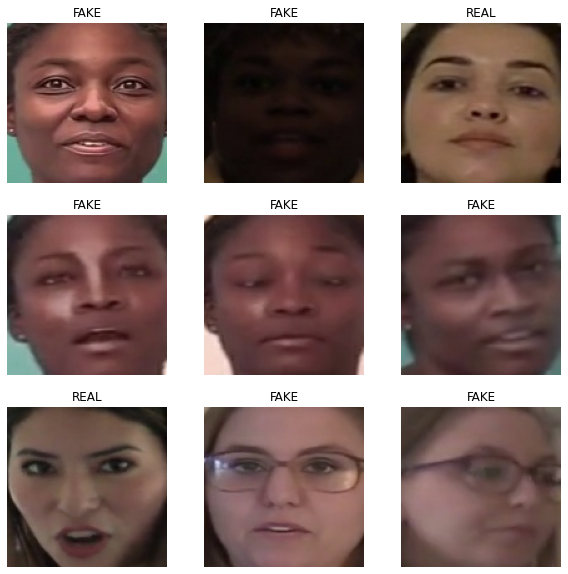

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [97]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [98]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [99]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [100]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97647065


In [83]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)       

In [86]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
45/45 [==============================] - 8s 167ms/step - loss: 0.5368 - accuracy: 0.7859 - val_loss: 0.4941 - val_accuracy: 0.8067
Epoch 2/10
45/45 [==============================] - 8s 173ms/step - loss: 0.5036 - accuracy: 0.7978 - val_loss: 0.4587 - val_accuracy: 0.8067
Epoch 3/10
45/45 [==============================] - 7s 153ms/step - loss: 0.4689 - accuracy: 0.7978 - val_loss: 0.4503 - val_accuracy: 0.8067
Epoch 4/10
45/45 [==============================] - 7s 154ms/step - loss: 0.4525 - accuracy: 0.7985 - val_loss: 0.4280 - val_accuracy: 0.8067
Epoch 5/10
45/45 [==============================] - 7s 145ms/step - loss: 0.4166 - accuracy: 0.8041 - val_loss: 0.4488 - val_accuracy: 0.8011
Epoch 6/10
45/45 [==============================] - 7s 152ms/step - loss: 0.3986 - accuracy: 0.8160 - val_loss: 0.3986 - val_accuracy: 0.8095
Epoch 7/10
45/45 [==============================] - 7s 159ms/step - loss: 0.3296 - accuracy: 0.8593 - val_loss: 0.3624 - val_accuracy: 0.8403
Epoch 

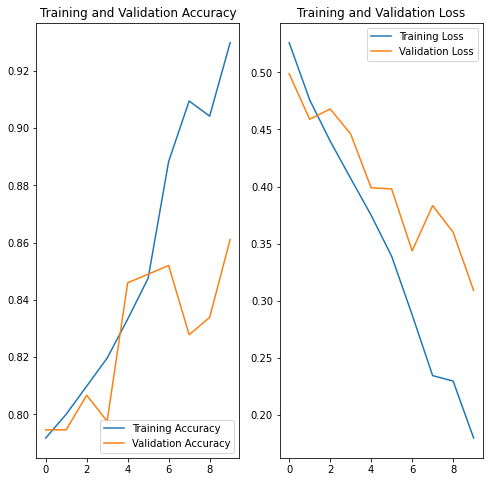

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [107]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

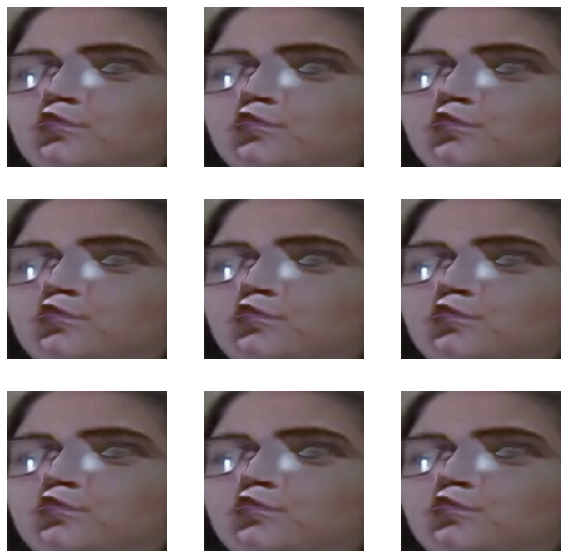

In [108]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [109]:
model = Sequential([
  # data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [110]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
52/52 [==============================] - 7s 132ms/step - loss: 0.5637 - accuracy: 0.7756 - val_loss: 0.4750 - val_accuracy: 0.8098
Epoch 2/15
52/52 [==============================] - 7s 129ms/step - loss: 0.5064 - accuracy: 0.7841 - val_loss: 0.4682 - val_accuracy: 0.8098
Epoch 3/15
52/52 [==============================] - 7s 128ms/step - loss: 0.4829 - accuracy: 0.7890 - val_loss: 0.4258 - val_accuracy: 0.8122
Epoch 4/15
52/52 [==============================] - 7s 129ms/step - loss: 0.4311 - accuracy: 0.8116 - val_loss: 0.3928 - val_accuracy: 0.8634
Epoch 5/15
52/52 [==============================] - 7s 133ms/step - loss: 0.3790 - accuracy: 0.8317 - val_loss: 0.3674 - val_accuracy: 0.8683
Epoch 6/15
52/52 [==============================] - 7s 137ms/step - loss: 0.3307 - accuracy: 0.8604 - val_loss: 0.3579 - val_accuracy: 0.8390
Epoch 7/15
52/52 [==============================] - 7s 137ms/step - loss: 0.2931 - accuracy: 0.8750 - val_loss: 0.3056 - val_accuracy: 0.8854
Epoch 

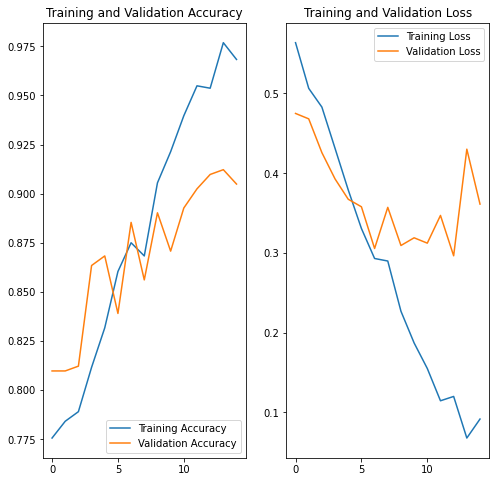

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [113]:
# Get all files in folder
train_files =  os.listdir("./data/processed/REAL")

reals = 0
for file in train_files:
    img = tf.keras.utils.load_img(
        f"./data/processed/REAL/{file}", target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])



    # print(
    #     "This image most likely belongs to {} with a {:.2f} percent confidence."
    #     .format(class_names[np.argmax(score)], 100 * np.max(score))
    # )

    if class_names[np.argmax(score)] == "REAL":
        reals += 1

print(reals/len(train_files))

0.8657407407407407


In [114]:
# Get all files in folder
train_files =  os.listdir("./data/processed/FAKE")

fakes = 0
for file in train_files:
    img = tf.keras.utils.load_img(
        f"./data/processed/FAKE/{file}", target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if class_names[np.argmax(score)] == "FAKE":
        fakes += 1

    # print(
    #     "This image most likely belongs to {} with a {:.2f} percent confidence."
    #     .format(class_names[np.argmax(score)], 100 * np.max(score))
    # )
print(fakes/len(train_files))

0.9833127317676144
